In [2]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import lightning.pytorch as L
from sklearn.model_selection import train_test_split

notebook_dir = os.getcwd() 
project_root = os.path.join(notebook_dir, '..')
sys.path.append(project_root)

print(f"Project root directory: {project_root}")

from SNeMPhyVAE.model.settings import initial_settings, band_info
from SNeMPhyVAE.model.lightcurves import LightCurves
from SNeMPhyVAE.model.spectra import Spectra

from SNeMPhyVAE.model.update import update_settings


Project root directory: /home/jurados/SNeMPhyVAE/notebooks/..
PROJECT_ROOT from settings: /home/jurados/SNeMPhyVAE
PROJECT_ROOT from lightcurve: /home/jurados/SNeMPhyVAE
PROJECT_ROOT from lightcurve: /home/jurados/SNeMPhyVAE


In [ ]:
#initial_settings = update_settings(initial_settings, ls_req=True)

initial_settings = initial_settings

# Load and process the light curves
lightcurves = LightCurves(settings=initial_settings, snii_only=False).obtain_data()
MLightCurve = LightCurves(instrument='ztf')
lightcurves = MLightCurve.process_lightcurves(lightcurves)
print('Lightcurves', lightcurves.head())
print('Lightcurves columns:', lightcurves.columns)
print('Lightcurves shape:', lightcurves.shape)
print('Number of lightcurves:', len(lightcurves.oid.unique()))

# Load and process the spectra
spectra = Spectra(settings=initial_settings, snii_only=False).obtain_data()
spectra = spectra[~spectra.oid.isin(['ZTF23aaoohpy', 'ZTF20aatzhhl', 'ZTF22aazuuin'])]
MSpectra = Spectra()
spectra  = MSpectra.preprocess_spectrum(spectra, slice_spectrum=True)

print('Spectra', spectra.head())
print('Spectra columns:', spectra.columns)
print('Spectra shape:', spectra.shape)
print('Number of spectra:', len(spectra.oid.unique()))
common_oids = set(spectra.oid.unique()) & set(lightcurves.oid.unique())
spectra     = spectra[spectra.oid.isin(common_oids)]
lightcurves = lightcurves[lightcurves.oid.isin(common_oids)]

# Obtain the redshift
lightcurves = lightcurves.merge(spectra[['oid', 'redshift']], on='oid', how='left')
lightcurves['redshift'] = lightcurves['redshift'].replace('nan', 0.1)

spectra = MSpectra.spectra_reference_time(spectra, lightcurves)

# Find common OIDs
try:
    oids = list(set(spectra.oid.unique()) & set(lightcurves.oid.unique()))#) & set(rainbow_spectra.oid.unique()))# & set(photo_vel.oid.unique()))
except:
    pass

test_oids = []
if 'ZTF22aaeviey' in oids:
    test_oids.append('ZTF22aaeviey')
    oids.remove('ZTF22aaeviey')  # Remove it from the main list

# 2. Split the 80% remaining into TRAIN (80%) and TEST (20%)
remaining_train_oids, remaining_test_oids = train_test_split(oids, test_size=0.2)

# 3. Ensure the special OID is in the test set
test_oids.extend(remaining_test_oids)
train_oids = remaining_train_oids

# Divide the data into training and validation sets per modality
train_data_lightcurves = lightcurves[lightcurves.oid.isin(train_oids)]
train_data_spectra     = spectra[spectra.oid.isin(train_oids)]
#train_data_rainbow     = rainbow_spectra[rainbow_spectra.oid.isin(train_oids)]
#train_data_photovel    = photo_vel[photo_vel.oid.isin(train_oids)]

#val_data_lightcurves = lightcurves[lightcurves.oid.isin(val_oids)]
#val_data_spectra     = spectra[spectra.oid.isin(val_oids)]
#val_data_rainbow     = rainbow_spectra[rainbow_spectra.oid.isin(val_oids)]

test_data_lightcurves = lightcurves[lightcurves.oid.isin(test_oids)]
test_data_spectra     = spectra[spectra.oid.isin(test_oids)]


#train_data_lightcurves = pd.read_pickle('./data/train_data_lightcurves.pkl')
#train_data_spectra     = pd.read_pickle('./data/train_data_spectra.pkl')
#test_data_lightcurves  = pd.read_pickle('./data/test_data_lightcurves.pkl')
#test_data_spectra      = pd.read_pickle('./data/test_data_spectra.pkl')
#
#special_oid = 'ZTF22aaeviey'

#train_data_lightcurves.to_pickle('train_data_lightcurves.pkl')
#test_data_lightcurves.to_pickle('test_data_lightcurves.pkl')
#train_data_spectra.to_pickle('train_data_spectra.pkl')
#test_data_spectra.to_pickle('test_data_spectra.pkl')

#Función para reordenar un DataFrame, poniendo special_oid primero
#def reorder_df(df, oid_col='oid', special_oid=special_oid):
#    if special_oid in df[oid_col].values:
#        # Separar el special_oid y el resto
#        special_data = df[df[oid_col] == special_oid]
#        other_data = df[df[oid_col] != special_oid]
#        # Concatenar con special_oid primero
#        return pd.concat([special_data, other_data], ignore_index=True)
#    return df
#
## Aplicar a ambos DataFrames de test
#test_data_lightcurves = reorder_df(test_data_lightcurves)
#test_data_spectra     = reorder_df(test_data_spectra)


/home/jurados/SNeMPhyVAE/notebooks/../SNeMPhyVAE/model/lightcurves.py:285: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.reset_index(drop=True))
/home/jurados/SNeMPhyVAE/notebooks/../SNeMPhyVAE/model/lightcurves.py:285: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.reset_index(drop=True))
/home/jurados/SNeMPhyVAE/notebooks/../SNeMPhyVAE/model/lightcurves.py:285: FutureWarning: Da

Lightcurves             oid               candid         rfid           mjd  fid  \
0  ZTF18aabukgo  1037513576315015000  712120263.0  58791.513576    2   
1  ZTF18aabukgo  1044541866315015000  712120263.0  58798.541863    2   
2  ZTF18aabukgo  1050551016315015000  712120263.0  58804.551018    2   
3  ZTF18aabukgo  1074429096315015000  712120263.0  58828.429097    2   
4  ZTF18aabukgo  1077452716315015000  712120263.0  58831.452720    2   

  source_id     firstmjd   Av_MW true_label          flux       fluxerr  \
0   2019tjj  58455.52294  0.0359       SNIa  5.479932e-27  2.357471e-28   
1   2019tjj  58455.52294  0.0359       SNIa  4.038499e-27  2.848028e-28   
2   2019tjj  58455.52294  0.0359       SNIa  3.586084e-27  2.055755e-28   
3   2019tjj  58455.52294  0.0359       SNIa  1.227427e-27  1.182133e-28   
4   2019tjj  58455.52294  0.0359       SNIa  1.189955e-27  1.401433e-28   

   grid_time  time_index  reference_time    flux_scale  
0 -13.080733         137    58804.558594  5.479

AttributeError: 'Spectra' object has no attribute 'process_spectrum'

In [ ]:
class CompleteDataset:
    def __init__(self, lightcurves, spectra):#0 rainbow, photovels):
        self.lightcurves = lightcurves
        self.spectra     = spectra
        #self.rainbow     = rainbow
        #self.photovels   = photovels

        # Agrupar por 'oid' y almacenar los grupos
        #self.oids = list(set(lightcurves.oid) & set(spectra.oid))# & set(rainbow.oid) & set(photovels.oid))
        oids = list(set(lightcurves['oid']) & set(spectra['oid'])) #& set(rainbow['oid']) & set(photovels['oid']))
        if 'ZTF22aaeviey' in oids:
            # Ensure 'ZTF22aaeviey' is at the beginning
            oids.remove('ZTF22aaeviey')
            oids.insert(0, 'ZTF22aaeviey')
        self.oids = oids

    def __len__(self):
        return len(self.oids)

    def __getitem__(self, idx):

        oid = self.oids[idx]
        lightcurve_group = self.lightcurves[self.lightcurves['oid'] == oid]
        spectrum_group   = self.spectra[self.spectra['oid'] == oid]
        #rainbow_group    = self.rainbow[self.rainbow['oid'] == oid]
        #photovel_group   = self.photovels[self.photovels['oid'] == oid]

        lightcurve_data = {
            'oid':            oid,
            'true_label':     lightcurve_group['true_label'],
            'mjd':            lightcurve_group['mjd'].to_numpy(dtype=np.float32),
            'redshift':       lightcurve_group['redshift'].astype(float).mean(),
            'fid':            lightcurve_group['fid'].to_numpy(dtype=np.uint8),
            'flux':           lightcurve_group['flux'].to_numpy(dtype=np.float32),
            'fluxerr':        lightcurve_group['fluxerr'].to_numpy(dtype=np.float32),
            'grid_time':      lightcurve_group['grid_time'].to_numpy(dtype=np.float32),
            'time_index':     lightcurve_group['time_index'].to_numpy(dtype=np.uint8),
            'reference_time': lightcurve_group['reference_time'].to_numpy(dtype=np.float32),
            'flux_scale':     lightcurve_group['flux_scale'].to_numpy(dtype=np.float32),
        }

        spectra_data = {
            'oid':             oid,
            'mjd':             spectrum_group['mjd'].to_numpy(),
            'flux':            spectrum_group['final_spectrum'].to_numpy(),
            'wave':            spectrum_group['wave'].to_numpy(),
            'lambda_grid_min': spectrum_group['lambda_grid_min'],
            'lambda_grid_max': spectrum_group['lambda_grid_max'],
            'nlambda_grid':    spectrum_group['nlambda_grid'].astype(int),
            'reference_time':  spectrum_group['reference_time'].astype(float),
            'time_index':      spectrum_group['time_index'].astype(int),
        }
        return lightcurve_data, spectra_data
    
train_dataset = CompleteDataset(train_data_lightcurves, train_data_spectra)
test_dataset  = CompleteDataset(test_data_lightcurves, test_data_spectra)
train_loader  = DataLoader(train_dataset, batch_size=64, collate_fn=list, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=64, collate_fn=list, shuffle=False)

In [2]:
batch, sbins, time_steps = 3, 100, 2

time = torch.linspace(-np.pi/2, 3*np.pi/2, sbins)
wave = torch.linspace(batch, time_steps, sbins)
tensor = torch.sin(time).unsqueeze(0).unsqueeze(-1).expand(batch, sbins, time_steps).permute(0,2,1)
tensor, tensor.shape, tensor.dtype, tensor.device

(tensor([[[-1.0000, -0.9980, -0.9920, -0.9819, -0.9679, -0.9501, -0.9284,
           -0.9029, -0.8738, -0.8413, -0.8053, -0.7660, -0.7237, -0.6785,
           -0.6306, -0.5801, -0.5272, -0.4723, -0.4154, -0.3569, -0.2969,
           -0.2358, -0.1736, -0.1108, -0.0476,  0.0159,  0.0792,  0.1423,
            0.2048,  0.2665,  0.3271,  0.3863,  0.4441,  0.5000,  0.5539,
            0.6056,  0.6549,  0.7015,  0.7453,  0.7861,  0.8237,  0.8580,
            0.8888,  0.9161,  0.9397,  0.9595,  0.9754,  0.9874,  0.9955,
            0.9995,  0.9995,  0.9955,  0.9874,  0.9754,  0.9595,  0.9397,
            0.9161,  0.8888,  0.8580,  0.8237,  0.7861,  0.7453,  0.7015,
            0.6549,  0.6056,  0.5539,  0.5000,  0.4441,  0.3863,  0.3271,
            0.2665,  0.2048,  0.1423,  0.0793,  0.0159, -0.0476, -0.1108,
           -0.1736, -0.2358, -0.2969, -0.3569, -0.4154, -0.4723, -0.5272,
           -0.5801, -0.6306, -0.6785, -0.7237, -0.7660, -0.8053, -0.8413,
           -0.8738, -0.9029, -0.9284, 

In [3]:
mask = tensor >= 0
mask, mask.shape, mask.dtype, mask.device

(tensor([[[False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False,  True,  True,  True,  True,  True,
            True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
            True,  True,  True,  True,  True, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False,
           False, False, Fa

In [4]:
positive = tensor * mask.float()
positive, positive.shape, positive.dtype, positive.device

(tensor([[[-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
           -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
           -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
           -0.0000, 0.0159, 0.0792, 0.1423, 0.2048, 0.2665, 0.3271, 0.3863,
           0.4441, 0.5000, 0.5539, 0.6056, 0.6549, 0.7015, 0.7453, 0.7861,
           0.8237, 0.8580, 0.8888, 0.9161, 0.9397, 0.9595, 0.9754, 0.9874,
           0.9955, 0.9995, 0.9995, 0.9955, 0.9874, 0.9754, 0.9595, 0.9397,
           0.9161, 0.8888, 0.8580, 0.8237, 0.7861, 0.7453, 0.7015, 0.6549,
           0.6056, 0.5539, 0.5000, 0.4441, 0.3863, 0.3271, 0.2665, 0.2048,
           0.1423, 0.0793, 0.0159, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
           -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
           -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
           -0.0000, -0.0000, -0.0000, -0.0000],
      

In [3]:
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

In [25]:
try:
    tensor = torch.tensor(spectra['flux'][0:4])
    #tensor = torch.tensor(spectra['flux_normalized'][0:2])
    tensor = tensor.unsqueeze(-1).expand(-1, -1, 300).permute(0,2,1)
    wave_full = torch.tensor(spectra['wave'][0:4])

    tensor.shape, wave_full.shape
except:
    tensor = tensor
    wave_full = wave.view(1, -1).expand(batch, -1)
    print(tensor.shape, wave_full.shape)


torch.Size([3, 2, 100]) torch.Size([3, 100])


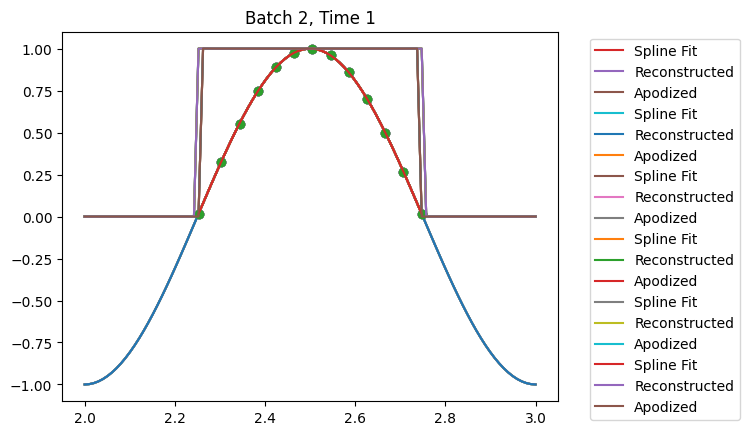

In [ ]:
tensor_vacio = torch.zeros_like(tensor)

for batch_idx in range(tensor.shape[0]):
    for time_idx in range(tensor.shape[1]):
        
        spectrum = tensor[batch_idx, time_idx, :]
        wave = wave_full[batch_idx, :]
        
        plt.plot(wave.cpu(), spectrum.cpu())
        plt.title(f'Batch {batch_idx}, Time {time_idx}')
        
        mask = spectrum >= 0
        idx_original = torch.where(mask)[0]
        #print(idx_original)
        
        if len(idx_original) < 3:  # Need at least 3 points for cubic spline
            # If not enough positive points, just copy the original spectrum
            tensor_vacio[batch_idx, time_idx, :] = spectrum
            continue

        wave_positive     = wave[idx_original]      
        spectrum_positive = spectrum[idx_original]
        
        plt.plot(wave_positive.cpu(), spectrum_positive.cpu())
        # Select 3 evenly spaced points from the positive spectrum
        spidx = torch.linspace(0, len(idx_original)-1, steps=13).long()
        idx_wave = idx_original[spidx]
        #print('idx_wave:', idx_wave)
        
        
        wave_npoints     = wave[idx_wave]
        spectrum_npoints = spectrum_positive[spidx]
        
        plt.plot(wave_npoints.cpu(), spectrum_npoints.cpu(), 'o')
        
        sorted_idx = torch.argsort(wave_npoints)
        wave_npoints = wave_npoints[sorted_idx]
        spectrum_npoints = spectrum_npoints[sorted_idx]
        
        # Create cubic spline using all positive points
        coeffs = natural_cubic_spline_coeffs(wave_npoints, spectrum_npoints.unsqueeze(-1))
        spline = NaturalCubicSpline(coeffs)
        
        # Evaluate spline at all positive wave positions
        spline_values = spline.evaluate(wave_positive).squeeze(-1)
        
        plt.plot(wave_positive.cpu(), spline_values.cpu(), label='Spline Fit')
        #plt.legend()
        
        # Create output tensor with same shape as original spectrum
        output_spectrum = torch.zeros_like(spectrum)
        # Fill in the spline values at positive positions
        #output_spectrum[idx_original] = spline_values
        output_spectrum[idx_original] = spectrum_positive / spline_values 
        
        plt.plot(wave.cpu(), output_spectrum.cpu(), label='Reconstructed')
        #plt.legend()
        
        #output_spectrum[idx_original] -= 1.0
        #
        n_positives = spectrum_positive.shape[0]
        n_apod      = max(1, int(n_positives * 0.05))
        apod_window = torch.ones(n_positives)
        #
        x = torch.linspace(00, np.pi/2, n_apod)
        apod_window[:n_apod] *= torch.sin(x)**2
        apod_window[-n_apod:] *= torch.sin(x.flip(0))**2
        #
        output_spectrum[idx_original] *= apod_window 
        output_spectrum = torch.nan_to_num(output_spectrum, nan=0.0, posinf=0.0, neginf=0.0)       
        
        plt.plot(wave.cpu(), output_spectrum.cpu(), label='Apodized')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        #output_spectrum[idx_original] -= 1.0
        #tensor_vacio[batch_idx, time_idx, :] = output_spectrum

#tensor_vacio, tensor_vacio.shape, tensor_vacio.dtype, tensor_vacio.device

In [7]:
batch, sbins, time_steps = 3, 100, 2

wave = torch.linspace(-np.pi/2, 3*np.pi/2, sbins)
tensor = torch.sin(wave).unsqueeze(0).unsqueeze(-1).expand(batch, sbins, time_steps).permute(0,2,1)
tensor, tensor.shape, tensor.dtype, tensor.device

print(tensor.shape, wave.shape)

wave = wave.view(1, -1).expand(batch, -1)
new_tensor = tensor.permute(2,0,1).reshape(100, -1)
print(new_tensor.shape, wave.shape)

torch.Size([3, 2, 100]) torch.Size([100])
torch.Size([100, 6]) torch.Size([3, 100])


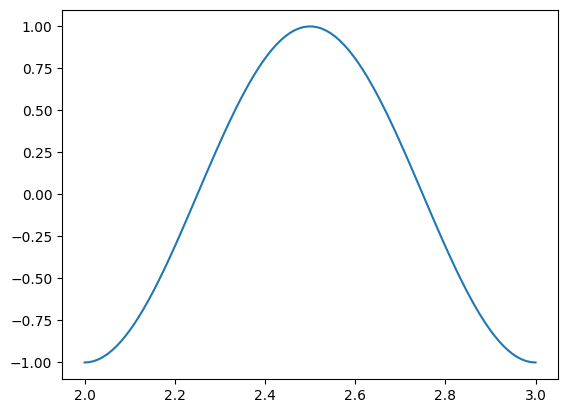

In [69]:
plt.plot(wave_full[0,:],new_tensor[:,0].cpu())

torch.Size([100, 6]) torch.Size([3, 100])
torch.Size([100, 6])
idx_original: torch.Size([100, 6])
spidx: tensor([ 0,  8, 16, 24, 33, 41, 49, 57, 66, 74, 82, 90, 99])
spectra_npoints: torch.Size([13, 6])
spline shape: torch.Size([100, 6])
normalized_spectra:  torch.Size([100, 6])


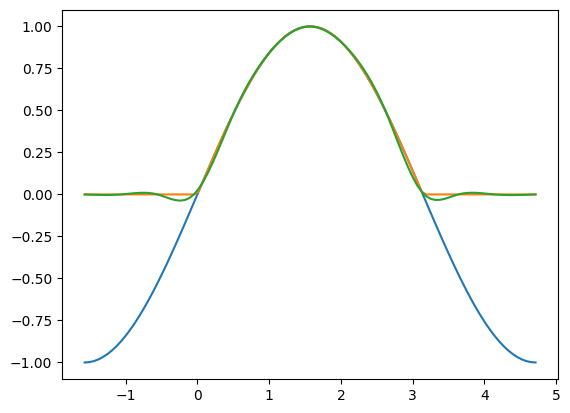

In [14]:
tensor_vacio = torch.zeros_like(new_tensor)
spectra = new_tensor
wave    = wave
print(spectra.shape, wave.shape)
print(tensor_vacio.shape)     

plt.plot(wave[0, :].cpu(), spectra[:,0].cpu())

mask = spectra >= 0
idx_original = torch.where(mask, spectra, torch.nan)
print("idx_original:", idx_original.shape)
spectra_positive = spectra * mask.float()

plt.plot(wave[0, :].cpu(), spectra_positive[:,0].cpu())

spidx = torch.linspace(0, spectra_positive.shape[0]-1, steps=13).long()
print('spidx:', spidx)

wave_npoints    = wave[0, spidx]
spectra_npoints = spectra_positive[spidx]
print('spectra_npoints:', spectra_npoints.shape)

coeffs = natural_cubic_spline_coeffs(wave_npoints, spectra_npoints)
spline = NaturalCubicSpline(coeffs)
spline_values = spline.evaluate(wave[0,:])

print('spline shape:',spline_values.shape)
plt.plot(wave[0, :].cpu(), spline_values[:,0].cpu())

normalized_spectrum = spectra / spline_values
#plt.plot(wave[0, :].cpu(), normalized_spectrum[:,0].cpu())
print('normalized_spectra: ',normalized_spectrum.shape)
#plt.title(f'Batch {batch_idx}, Time {time_idx}')
#ave
#mask = spectrum >= 0
#idx_original = torch.where(mask)[0]
##print(idx_original)
#
#if len(idx_original) < 3:  # Need at least 3 points for cubic spline
#    # If not enough positive points, just copy the original spectrum
#    tensor_vacio[batch_idx, time_idx, :] = spectrum
#    continue
#
#wave_positive     = wave[idx_original]      
#spectrum_positive = spectrum[idx_original]
#
#plt.plot(wave_positive.cpu(), spectrum_positive.cpu())
## Select 3 evenly spaced points from the positive spectrum
#spidx = torch.linspace(0, len(idx_original)-1, steps=13).long()
#idx_wave = idx_original[spidx]
##print('idx_wave:', idx_wave)
#
#
#wave_npoints     = wave[idx_wave]
#spectrum_npoints = spectrum_positive[spidx]
#
#plt.plot(wave_npoints.cpu(), spectrum_npoints.cpu(), 'o')
#
#sorted_idx = torch.argsort(wave_npoints)
#wave_npoints = wave_npoints[sorted_idx]
#spectrum_npoints = spectrum_npoints[sorted_idx]
#
## Create cubic spline using all positive points
#coeffs = natural_cubic_spline_coeffs(wave_npoints, spectrum_npoints.unsqueeze(-1))
#spline = NaturalCubicSpline(coeffs)
#
## Evaluate spline at all positive wave positions
#spline_values = spline.evaluate(wave_positive).squeeze(-1)
#
#plt.plot(wave_positive.cpu(), spline_values.cpu(), label='Spline Fit')
##plt.legend()
#
## Create output tensor with same shape as original spectrum
#output_spectrum = torch.zeros_like(spectrum)
## Fill in the spline values at positive positions
##output_spectrum[idx_original] = spline_values
#output_spectrum[idx_original] = spectrum_positive / spline_values 
#
#plt.plot(wave.cpu(), output_spectrum.cpu(), label='Reconstructed')
##plt.legend()
#
##output_spectrum[idx_original] -= 1.0
##
#n_positives = spectrum_positive.shape[0]
#n_apod      = max(1, int(n_positives * 0.05))
#apod_window = torch.ones(n_positives)
##
#x = torch.linspace(00, np.pi/2, n_apod)
#apod_window[:n_apod] *= torch.sin(x)**2
#apod_window[-n_apod:] *= torch.sin(x.flip(0))**2
##
#output_spectrum[idx_original] *= apod_window 
#output_spectrum = torch.nan_to_num(output_spectrum, nan=0.0, posinf=0.0, neginf=0.0)       
#
#plt.plot(wave.cpu(), output_spectrum.cpu(), label='Apodized')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
##output_spectrum[idx_original] -= 1.0
##tensor_vacio[batch_idx, time_idx, :] = output_spectrum
#
##tensor_vacio, tensor_vacio.shape, tensor_vacio.dtype, tensor_vacio.device

In [ ]:
import torch
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)

t = torch.linspace(0, 1, 7)
# (2, 1) are batch dimensions. 7 is the time dimension
# (of the same length as t). 3 is the channel dimension.
x = torch.rand(2, 1, 7, 3)
coeffs = natural_cubic_spline_coeffs(t, x)
# coeffs is a tuple of tensors

# ...at this point you can save the coeffs, put them
# through PyTorch's Datasets and DataLoaders, etc...

spline = NaturalCubicSpline(coeffs)

point = torch.tensor(0.4)
# will be a tensor of shape (2, 1, 3), corresponding to
# batch, batch, and channel dimensions
out = spline.derivative(point)

point = torch.tensor([[0.4, 0.5]])
# will be a tensor of shape (2, 1, 1, 2, 3), corresponding to
# batch, batch, time, time and channel dimensions
out = spline.derivative(point)

plt.plot(t,)

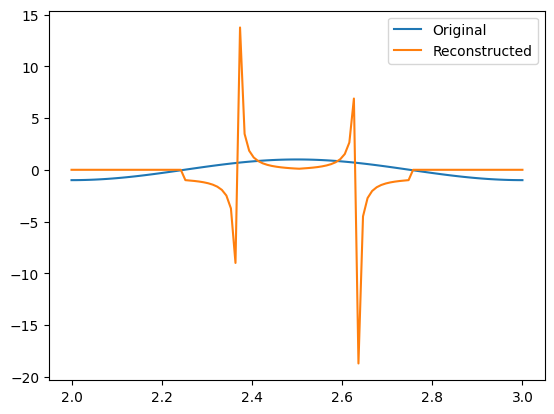

In [17]:
idxbatch, idxtime = 2, 1
plt.plot(wave_full[idxbatch,:], tensor[idxbatch, idxtime, :].cpu(), label='Original')
plt.plot(wave_full[idxbatch,:], tensor_vacio[idxbatch, idxtime, :].cpu(), label='Reconstructed')
plt.legend()

In [45]:
B, T, N = tensor.shape
window_size = 100

In [85]:
kernel = torch.ones(window_size) / window_size
print(kernel.shape)
kernel = kernel.view(1,1,-1)
print(kernel.shape)
print(tensor.shape)

tensor_smooth = tensor.reshape(tensor.shape[0]*tensor.shape[1], 1, tensor.shape[2])
print(tensor_smooth.shape)

mask = (tensor_smooth != 0).float()
print(mask, mask.shape)

torch.Size([100])
torch.Size([1, 1, 100])
torch.Size([4, 300, 1838])
torch.Size([1200, 1, 1838])
tensor([[[1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]]) torch.Size([1200, 1, 1838])


In [12]:
pad_size = (window_size - 1) // 2
tensor_pad = F.pad(tensor_smooth, (pad_size, pad_size), mode='reflect')
mask_pad   = F.pad(mask, (pad_size, pad_size), mode='reflect')
print(tensor_pad.shape, mask_pad.shape)

smoothed = F.conv1d(tensor_pad, kernel)
mask_smoothed = F.conv1d(mask_pad, kernel)
print(smoothed.shape, mask_smoothed.shape)


NameError: name 'window_size' is not defined

In [1]:
sweep_config = {
    'method': 'random'
}

In [2]:
metric = {
    'name' : 'loss',
    'goal' : 'minimize'
}

sweep_config['metric'] = metric

In [3]:
sweep_config

{'method': 'random', 'metric': {'name': 'loss', 'goal': 'minimize'}}